In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
import cv2
from os.path import abspath
from os.path import join as p_join
from pathlib import Path 
import os
import scipy
import librosa
import librosa.display

import matplotlib
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['image.cmap'] = 'gray'
data_fpath = p_join(abspath(''), 'data')
print(data_fpath)

C:\Users\Theresa\Documents\CS_Master\EPFL\CM\Project\AudioImagers\data


In [2]:
# we will need some real-world audio for some examples. 
from IPython.display import Audio
from scipy.io import wavfile

# Brandenburg concerto #1, mono, 8 kHz
audio_sample_sf, audio_sample = wavfile.read(p_join(data_fpath, "brand1.wav"))
audio_sample = audio_sample / 32767.0
print("duration:", len(audio_sample), "sample rate:", audio_sample_sf, "length=", len(audio_sample)/audio_sample_sf)
Audio(audio_sample, rate=audio_sample_sf)

duration: 63923 sample rate: 8000 length= 7.990375


functions for transforming image 

In [3]:
import scipy.interpolate as interpolate
from scipy import optimize


def sharpen_from_kernel_center(center, im):
    # creates a sharpening kernel with the given center magnitude that defines the degree of sharpening/blurring
    other = -(center-1)/8
    kernel = np.array([[other,other,other], [other,center,other], [other,other,other]])
    img = cv2.filter2D(im, -1, kernel)
    return img


def change_laplacian(im, target_value, plot=False):
    """
    reads image, manipulates sharpness and writes again to temporary file
    """
    # do not change if target is 0 bc then the feature is not relevant
    if target_value == 0:
        return im
    
    # calculate the current laplacian value
    lap = cv2.Laplacian(im, -1, ksize=1)
    before = lap.var()

    # the amount of change in the laplacian depends on the kernel magnitude (-> the value at the center of the kernel)
    # we can model the laplacian as a function of this center value.
    # this function is mostly quadratic -> compute sharpness values for a few center values and interpolate with quadratic/cubic function
    # then find the center value that corresponds to the desired sharpness according to the interpolation
    vars = []
    # use 5 values for the interpolation
    interpolation_space = np.linspace(0,5,5)
    for c in interpolation_space:
        # sharpen/blur (center<1?) image with kernel with given center. 
        img = sharpen_from_kernel_center(c, im)
        # compute laplacian of modified image
        v = cv2.Laplacian(img, -1, ksize=1).var()
        vars += [v]
    # interpolate (center, laplacian) pairs
    interp_fn = interpolate.interp1d(interpolation_space,vars,kind='cubic', fill_value='extrapolate')
    # subtract target_value so that the 0 crossing corresponds to the desired value
    interp_fn2 = lambda x: (interp_fn(x)-target_value)

    # if the desired laplacian is not reachable, use the smallest possible
    if target_value <= interp_fn(0):
        center = 0
    # else find the kernel center that comes closest to the desired laplacian by finding 0-crossing
    else :
        center = optimize.newton(interp_fn2, 3, tol=10**(-10))
    
    # sharpen image with found center
    im = sharpen_from_kernel_center(center, im)

    return im

In [4]:
def change_hsv(im, target_values, change_hue=False):
    """
    reads image, manipulates HSV channels and writes back to file
    """
    im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    # current HSV values of image
    HSV = np.mean(np.mean(im, axis = 1), axis=0)
    difference = target_values - HSV

    # we do not always want to modify the hue because the overlapping with RGB is very strong and hue is angular so the mean of hues is not very meaningful
    # we only change the hue if RGB are not changed
    if change_hue:
        start = 0
    else: 
        start = 1

    for i in range(start, 3):
        # do not change if target value is 0 bc then the feature is not relevant
        if target_values[i]==0:
            continue
        # difference image for cv2.subtract/add
        diff = np.zeros_like(im)
        # fill with the magnitude of the difference between the means
        diff[:,:,i] = abs(difference[i])
        # if difference is negative we need to decrease the mean of the channel i
        if difference[i] < 0:
            im = cv2.subtract(im, diff)
        # if positive we need to increase it
        else:
            im = cv2.add(im, diff)
    # convert back to rgb space
    im = cv2.cvtColor(im, cv2.COLOR_HSV2RGB)
    return im

In [5]:
def change_rgb(im, target_values):
    """
    reads image, manipulates bgr channels and writes back to file
    """
    # current BGR values of image
    RGB = np.mean(np.mean(im, axis = 1), axis=0)
    difference = target_values - RGB
    for i in range(3):
        # do not change if target value is 0 bc that means that the feature is not relevant
        if target_values[i] == 0:
            continue
        # difference image for cv2.subtract/add
        diff = np.zeros_like(im)
        # fill with the magnitude of the difference between the means
        diff[:,:,i] = abs(difference[i])
        # if difference is negative we need to decrease the mean of the channel i
        if difference[i] < 0:
            im = cv2.subtract(im, diff)
        # if positive we need to increase it
        else:
            im = cv2.add(im, diff)
    # write the resulting image back to the file
    return im

In [6]:
def transform_image(target_values, im):
    im_new = im.copy()
    # change feature values to mean values of target emotion
    im_new = change_rgb(im_new, target_values[['red', 'green', 'blue']].values[0])
    if np.all(target_values[['red', 'green', 'blue']].values[0]==0):
        im_new = change_hsv(im_new, target_values[['hue', 'saturation', 'brightness']].values[0], change_hue=True)
    else:
        im_new = change_hsv(im_new, target_values[['hue', 'saturation', 'brightness']].values[0], change_hue=False)

    im_new = change_laplacian(im_new, target_values['sharpness'].values)
    return im_new

Read test image

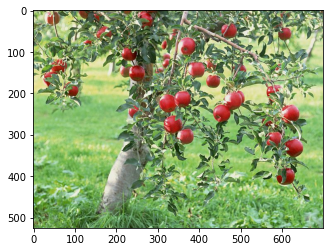

In [7]:
import pandas as pd
image_path = p_join(data_fpath, "apples.jpg")

im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

transform with random values

mean RGB before [134.59251700680272, 157.93769523809524, 102.53281088435374]
mean RGB after [212.54266394557823, 117.75204081632653, 23.85185850340136]


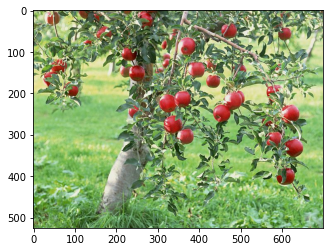

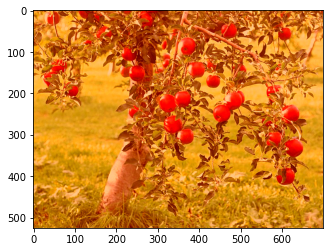

In [8]:
import pandas as pd
image_path = p_join(data_fpath, "apples.jpg")

im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

target_values = {'hue': 0, 'saturation': 0, 'brightness':0, 'red': 222, 'blue': 10, 'green': 117, 'sharpness': 0}
df = pd.DataFrame()
df = df.append(target_values, ignore_index=True)


im_new = transform_image(df, im)
print("mean RGB before", [np.mean(im[:,:,i]) for i in range(3)])
print("mean RGB after", [np.mean(im_new[:,:,i]) for i in range(3)])
plt.imshow(im)
plt.show()
plt.imshow(im_new)

example mapping: map change in amplitude to change in RGB values

1. bin frequencies of sample into 3 bins (low, middle, high frequencies)
2. compute the mean amplitude of each bin
3. compute mean RGB values of image
4. ratio of new amplitudes to old amplitudes defines ratio of new RGB to old RGB
5. change image accordingly

repeat over 10 disjoint time samples of the audio

In [80]:
def get_bins(sample, audio_sample_sf, num_bins):
    fmax = audio_sample_sf / 2
    N = int(len(sample) * fmax / audio_sample_sf)
    X = np.abs(np.fft.fft(sample)[0:N])
    bin_size = int(len(X)/num_bins)
    # bin the frequencies into three channels (low, middle, high frequencies) and compute average amplitude for each bin
    binned_freq = np.array([np.mean(X[i*bin_size : (i+1)*bin_size]) for i in range(num_bins)])
    return binned_freq

In [83]:
def sound_to_image(audio_sample, audio_sample_sf, im, num_time_bins = 10, mode="maximum", window_size=100):
    """
    mode:
    maximum = map the whole amplitude range to the whole color range
    window = map the whole amplitude range to a color range of size window_size
    """
    fmax = audio_sample_sf / 2
    time_bin_size = int(len(audio_sample)/num_time_bins)
    print(time_bin_size)
    widths = np.linspace(0,num_time_bins*0.04,num_time_bins)
    fig,ax = plt.subplots()
    
    mean_rgb = np.array([np.mean(im[:,:,i]) for i in range(3)])
    r = [mean_rgb[0]]
    g = [mean_rgb[1]]
    b = [mean_rgb[2]]
    im_prev = im

    # first sample
    sample = audio_sample[:time_bin_size]
    num_bins = 3
    binned_freq_prev = get_bins(sample, audio_sample_sf, num_bins)
    
    # just for plotting
    low = [binned_freq_prev[0]]
    mid = [binned_freq_prev[1]]
    high = [binned_freq_prev[2]]
    
    # find maximum amplitude of first sample to get upper bound for the mapping
    max_ampl = (255 * np.array([6,6,6]))/mean_rgb # (255 * binned_freq_prev) / mean_rgb
    print("maximum amplitude", max_ampl, "(==255 in rgb)")
    # window
    if mode=="window":
        lower, upper = get_bounds(mean_rgb, binned_freq_prev, max_ampl, window_size)
        print("range:", lower, " to ", upper)
    else:
        lower = 0
        upper = 0

    print("initial RGB", mean_rgb)
    print("initial amplitude", binned_freq_prev)
    
    ax.bar(np.arange(num_bins)+widths[0], binned_freq_prev, width=0.051)
    ax.set_xticks(np.arange(num_bins))
    ax.set_xticklabels(((np.arange(1,num_bins+1)/num_bins)*fmax).astype(int), rotation=65)

    # loop over samples (make them overlapping?)
    for i in range(1,num_time_bins):
        sample = audio_sample[i*time_bin_size:(i+1)*time_bin_size]

        binned_freq_curr = get_bins(sample, audio_sample_sf, num_bins)
        print("amplitude", binned_freq_curr)

        low += [binned_freq_curr[0]]
        mid += [binned_freq_curr[1]]
        high += [binned_freq_curr[2]]

        fig2,ax2 = plt.subplots(1,2)
        ax.bar(np.arange(num_bins)+widths[i], binned_freq_curr, width=0.051)
        ax.set_xticks(np.arange(num_bins))
        ax.set_xticklabels(((np.arange(1,num_bins+1)/num_bins)*fmax).astype(int), rotation=65)

        # modify image accordingly
        # compute RGB values of previous image
        # prev_values = np.array([np.mean(im_prev[:,:,i]) for i in range(3)])
        # change according to change in frequency 
        # ratio of frequencies = ratio of colors
        if mode == "maximum":
            # ration of frequency to max frequency = ratio of color to max color
            new_values = (255 * binned_freq_curr) / max_ampl
        # get new values in given range (not from 0 to 255 but lower to upper which is a span of "color_range")
        else:
            new_values = get_new_rgb_from_range(lower, upper, max_ampl, binned_freq_curr)
        #new_values = ((prev_values) * binned_freq_curr)/(binned_freq_prev) # (255 * binned_freq_curr) / max_ampl #(prev_values * binned_freq_curr)/binned_freq_prev
        
        r += [new_values[0]]
        g += [new_values[1]]
        b += [new_values[2]]
        print("target RGB: ",new_values)
        target_values = {'hue': 0, 'saturation': 0, 'brightness':0, 'red': new_values[0], 'green': new_values[1], 'blue': new_values[2], 'sharpness': 0}

        df = pd.DataFrame()
        df = df.append(target_values, ignore_index=True)
        im_new = transform_image(df, im)
        old_means = [np.mean(im_prev[:,:,i]) for i in range(3)]
        new_means = [np.mean(im_new[:,:,i]) for i in range(3)]

        ax2[0].imshow(im_prev)
        ax2[1].imshow(im_new)

        print("old means BGR", [np.mean(im_prev[:,:,i]) for i in range(3)])
        print("new means BGR", [np.mean(im_new[:,:,i]) for i in range(3)], "\n")

        #binned_freq_prev = binned_freq_curr
        im_prev = im_new

    ax.set_title("frequency binned vs mean amplitude. colors=time snippets")
    ax.set_xlabel("frequency")
    ax.set_ylabel("mean amplitude")
    fig.tight_layout()
    plt.show()
    return r,g,b,low,mid,high

For a linear mapping we first have to define the range of amplitudes that we want to be able to map since the color range is fixed to $[0,255]$.
With the first sound sample we get the first three amplitudes (average amplitude of binned low, mid and high frequencies) and the initial mean RGB values from the image. We know that we want to map these amplitudes to these RGBs but how do we know to which RGBs we map a new amplitude? To do this, we first have to "calibrate" the linear mapping that will translate the amplitude to a color. 

Let's focus on the red channel and the low frequencies for now, since we should define a different mapping for each color channel anyhow. We know that the red values are in a fixed range $[0,255]$. For the amplitude we know the lower bound, 0, but not the upper. But we know another pair: the given initial amplitude and red value $(a_R, R)$. With these two points $(0,0)$ and $(a_R, R)$. we can define a linear mapping. There are several ways to get this mapping, we will do it by finding the maximum amplitude first:

$\frac{a_R}{R} = \frac{a_{max}}{255} \to a_{max} = \frac{255 \cdot a_R}{R}$

We use this to transfer a new amplitude $a_R'$ from the range $[0,a_{max}]$ to $[0,255]$ ot get the corresponding red value $R'$:

$R' = \frac{a'_R \cdot 255}{a_{max}}$


In [79]:
num_time_bins = 100
im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
r,g,b, low,mid,high = sound_to_image(audio_sample, audio_sample_sf, im, num_time_bins, mode="maximum", window_size=50)

639
319
maximum amplitude [11.36764535  9.68736436 14.92205263] (==255 in rgb)
initial RGB [134.59251701 157.93769524 102.53281088]
initial amplitude [0.01101502 0.00168385 0.00124816]
319
amplitude [0.54162398 0.24562598 0.37767858]
target RGB:  [12.14975589  6.46560016  6.45407444]
old means BGR [134.59251700680272, 157.93769523809524, 102.53281088435374]
new means BGR [27.492155102040815, 27.327126530612244, 21.779891156462586] 

319
amplitude [2.85473786 0.46161614 0.3553789 ]
target RGB:  [64.03772566 12.15109825  6.07299956]
old means BGR [27.492155102040815, 27.327126530612244, 21.779891156462586]
new means BGR [66.56005442176871, 30.792473469387755, 21.69481904761905] 

319
amplitude [3.0240348  0.35732848 0.29594746]
target RGB:  [67.83540916  9.40593941  5.05738748]
old means BGR [66.56005442176871, 30.792473469387755, 21.69481904761905]
new means BGR [70.17225850340137, 28.956285714285713, 21.1494693877551] 

319
amplitude [2.26106956 0.31491559 0.24157196]
target RGB:  [50.

old means BGR [114.62499047619048, 43.31155646258503, 23.96154557823129]
new means BGR [92.90385034013606, 46.17149115646259, 22.24562993197279] 

319
amplitude [6.82415178 2.14526301 0.65121191]
target RGB:  [153.07996077  56.46964932  11.12843133]
old means BGR [92.90385034013606, 46.17149115646259, 22.24562993197279]
new means BGR [152.41981224489797, 62.268674829931975, 24.545912925170068] 

319
amplitude [7.03393706 1.58608583 0.51991185]
target RGB:  [157.7858822   41.75045681   8.8846705 ]
old means BGR [152.41981224489797, 62.268674829931975, 24.545912925170068]
new means BGR [157.2964299319728, 50.53601088435374, 23.37254693877551] 

319
amplitude [7.15525819 1.87133781 0.59113484]
target RGB:  [160.50736819  49.25913014  10.10178615]
old means BGR [157.2964299319728, 50.53601088435374, 23.37254693877551]
new means BGR [159.23030476190476, 56.669714285714285, 23.94808707482993] 

319
amplitude [5.21640376 1.52238147 0.46321263]
target RGB:  [117.01481852  40.07357022   7.91574

old means BGR [133.5926829931973, 86.49635646258504, 31.54787755102041]
new means BGR [123.60150476190476, 59.029967346938776, 26.98764081632653] 

319
amplitude [5.61109798 2.3164933  0.6379086 ]
target RGB:  [125.86863336  60.97693553  10.90109356]
old means BGR [123.60150476190476, 59.029967346938776, 26.98764081632653]
new means BGR [126.59770612244898, 66.38737142857143, 24.555303401360543] 

319
amplitude [4.09601257 2.16587521 0.49523035]
target RGB:  [91.88210697 57.0122232   8.46289326]
old means BGR [126.59770612244898, 66.38737142857143, 24.555303401360543]
new means BGR [92.86449523809524, 63.14173605442177, 22.812843537414967] 

319
amplitude [5.47375198 2.20911718 1.13318006]
target RGB:  [122.78767617  58.15047926  19.3646895 ]
old means BGR [92.86449523809524, 63.14173605442177, 22.812843537414967]
new means BGR [123.60150476190476, 63.89945306122449, 29.547404081632653] 

319
amplitude [5.48760867 3.07191281 1.35948527]
target RGB:  [123.09851063  80.86180483  23.23197

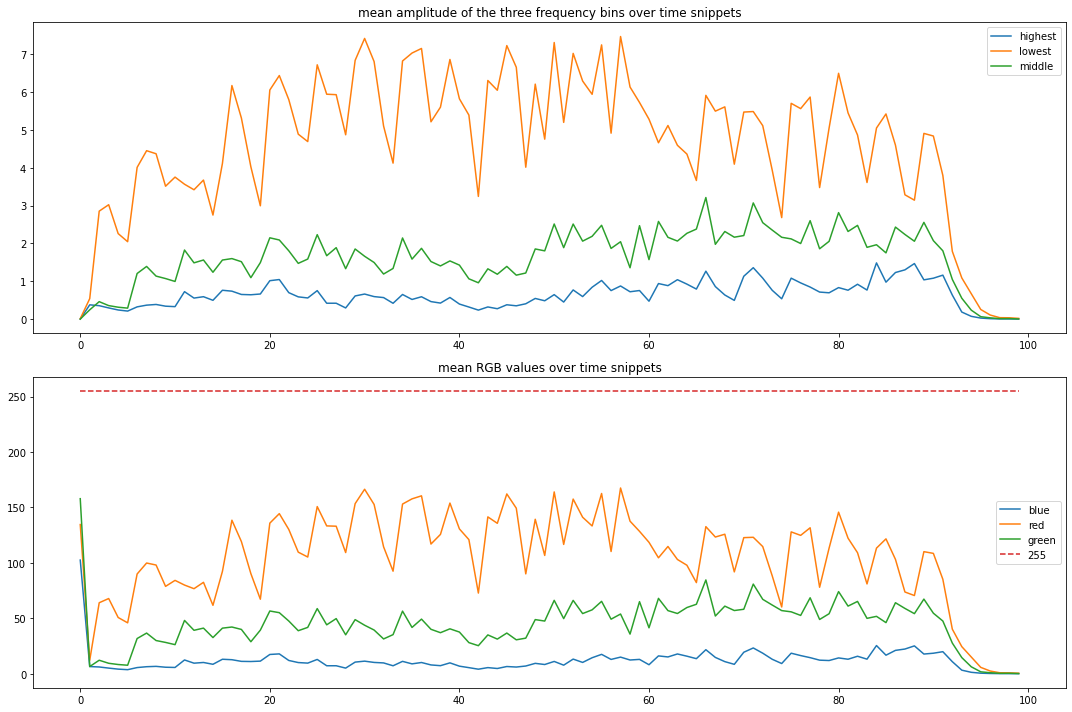

In [81]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[1].plot(np.arange(num_time_bins), b, label="blue")
ax[1].plot(np.arange(num_time_bins), r, label="red")
ax[1].plot(np.arange(num_time_bins), g, label="green")
ax[1].plot([0,num_time_bins-1], [255,255], "--", label="255")
ax[1].legend()
ax[1].set_title("mean RGB values over time snippets")
ax[0].plot(np.arange(num_time_bins), high, label="highest")
ax[0].plot(np.arange(num_time_bins), low, label="lowest")
ax[0].plot(np.arange(num_time_bins), mid, label="middle")
ax[0].legend()
ax[0].set_title("mean amplitude of the three frequency bins over time snippets")
fig.tight_layout()


However, if $a_R' > a_{max}$ we will get a value that is larger than 255. And indeed, we see that very often the computed RGB values exceed 255 and the image saturates. Because we do not know the biggest amplitude value we will see in all sound samples we cannot find a linear mapping that never exceeds 255.

But we can try to make smaller changes to the RGB so that the chance that the image saturates is lower. One way to do this is to map the whole amplitude range not to the whole color range but to a smaller range around the RGB values of the intial image.
In the previous mapping we have mapped the amplitude value 0 to color value 0 and amplitude max_ampl to 255. When the new amplitude extends the max amplitude, we exceed the limit of the color channels 255. Instead we now map the amplitude range $[0,a_{max}]$ to to a color range [upper, lower] such that the ratio $\frac{a_{max}-0}{a_R-0}$ is preserved in $\frac{upper-lower}{R-lower}$.

We calculate lower and upper like this:

$lower = f(0) = R - (\frac{a_R}{a_{max}} \cdot color\_range)$ </br>
$upper = f(a_{max}) = R + (1 - \frac{a_R}{a_{max}}) \cdot color\_range$

f is then defined as:

$f(a) = \frac{a}{a_{max}} \cdot (upper - lower) + lower$

If we now get a high amplitude and exceed the range [lower, upper] a bit, it is not such a big problem because we still get some valid ($\leq 255$) values. (It can still happen however. We have to decrease the window size then)

In [13]:
def get_bounds(initial_rgb, initial_ampl, max_ampl, color_range):
    lower = initial_rgb - ((initial_ampl/max_ampl) * color_range)
    upper = initial_rgb + ( (1-(initial_ampl/max_ampl)) * color_range)
    return lower, upper

In [14]:
def get_new_rgb_from_range(lower, upper, max_ampl, ampl):
    return (ampl/max_ampl) * (upper-lower) + lower

define a range for RGB value changes that corresponds to the range of possible amplitudes (0, max_ampl).
ex. range = 50 for a given max_ampl and initial amplitudes and initial RGB value. Then the range of values we can achieve is:

lower = initial RGB - (initial amplitudes/max_ampl) $\cdot $ 50 </br>
upper = initial RGB + (1 - initial amplitudes/max_ampl) $\cdot $ 50

Given a new amplitude $a$ from a new sound sample we can calculate the corresponding change in RGB with:

$\frac{a}{max\_ampl} \cdot (upper - lower) + lower$

example

In [15]:
max_ampl = 10
initial_ampl = 3
color_range = 50
initial_rgb = 100
lower, upper = get_bounds(initial_rgb, initial_ampl, max_ampl, color_range)
print("amplitude range:", 0, "to", max_ampl)
print("initial amplitude=", initial_ampl, "should correspond to intial color value=",initial_rgb)
print("then:")
print("color range", lower, "to", upper)
print("range below current RGB:",initial_rgb-lower,"and above:", upper-initial_rgb)
print("range below current amplitude:", initial_ampl,"and above:", max_ampl-initial_ampl)
print(f"ratios are preserved: max_ampl/initial_ampl = {max_ampl/initial_ampl:.2} = {(upper-lower)/(initial_rgb-lower):.2} = range/(initial-lower). i.e. the range of amplitude values we have below the current amplitude corresponds to the range we have for the RGB values. Same for values higher than current amplitude.")

new_ampl = 7
new_color = get_new_rgb_from_range(lower, upper, max_ampl, new_ampl)
print(f"a new amplitude of {new_ampl} maps to f({new_ampl})={new_color}")

amplitude range: 0 to 10
initial amplitude= 3 should correspond to intial color value= 100
then:
color range 85.0 to 135.0
range below current RGB: 15.0 and above: 35.0
range below current amplitude: 3 and above: 7
ratios are preserved: max_ampl/initial_ampl = 3.3 = 3.3 = range/(initial-lower). i.e. the range of amplitude values we have below the current amplitude corresponds to the range we have for the RGB values. Same for values higher than current amplitude.
a new amplitude of 7 maps to f(7)=120.0


6392
maximum amplitude [11.36764535  9.68736436 14.92205263] (==255 in rgb)
range: [ 85.0196325  141.67467444  98.36098252]  to  [155.0196325  211.67467444 168.36098252]
initial RGB [134.59251701 157.93769524 102.53281088]
initial amplitude [8.05038529 2.2506544  0.88931775]
amplitude [11.08001509  4.39968337  1.77710789]
target RGB:  [153.24845493 173.46638008 106.69747318]
old means BGR [134.59251700680272, 157.93769523809524, 102.53281088435374]
new means BGR [152.0111836734694, 172.67228027210885, 106.06174421768708] 

amplitude [16.83636701  5.41514095  2.04368898]
target RGB:  [188.69507754 180.80398274 107.94801671]
old means BGR [152.0111836734694, 172.67228027210885, 106.06174421768708]
new means BGR [185.5203455782313, 179.3148244897959, 107.04390204081632] 

amplitude [19.37688052  5.04765948  1.66843378]
target RGB:  [204.3391217  178.14859556 106.18767817]
old means BGR [185.5203455782313, 179.3148244897959, 107.04390204081632]
new means BGR [198.3133306122449, 177.3027918

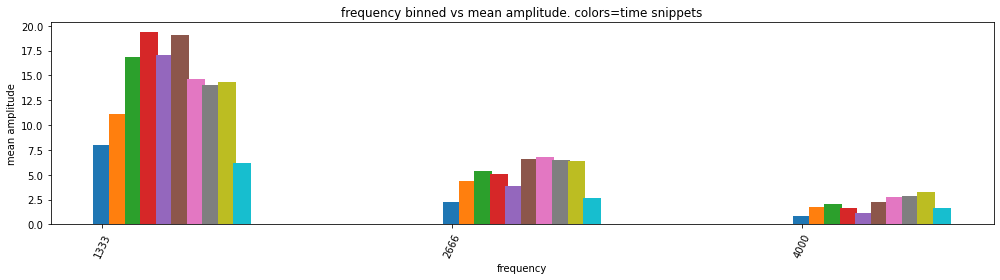

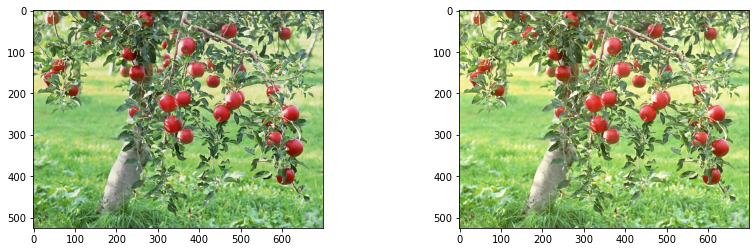

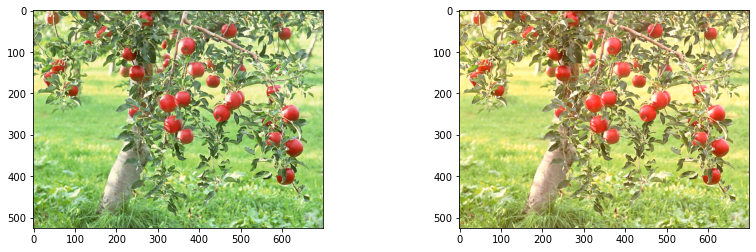

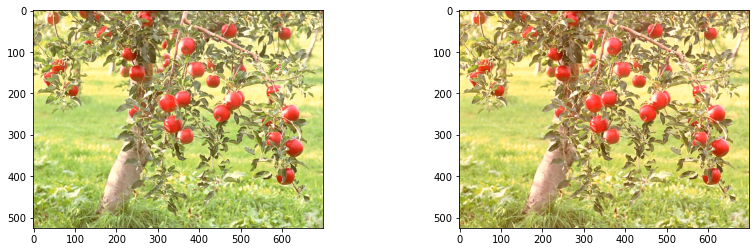

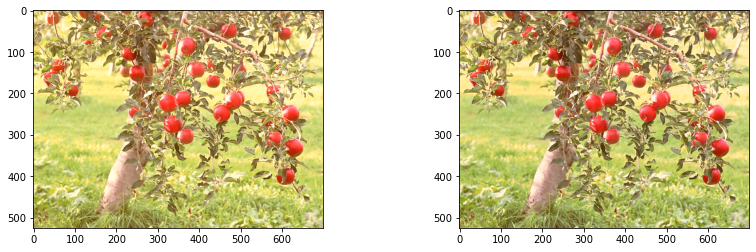

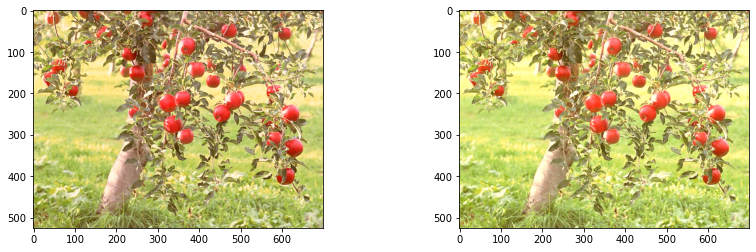

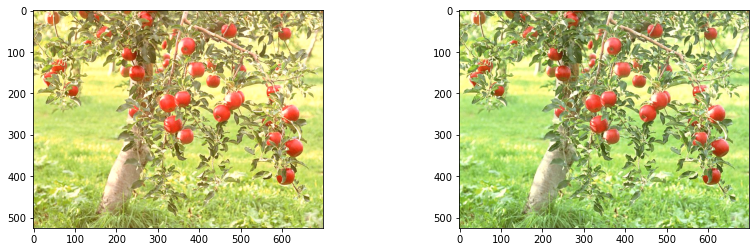

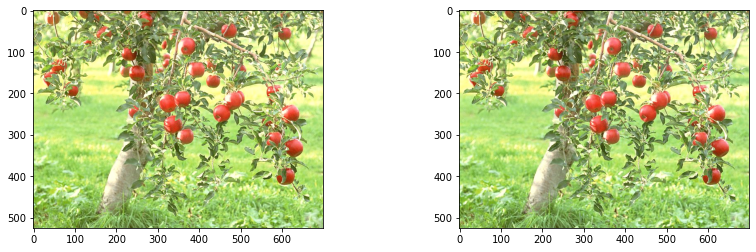

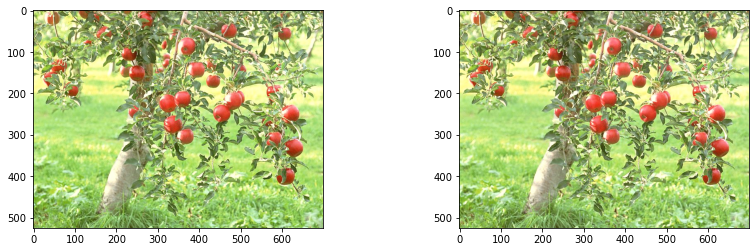

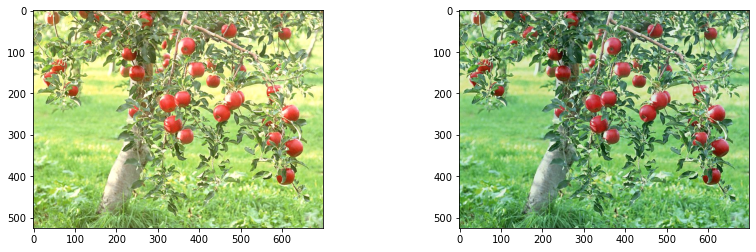

In [84]:
r,g,b, low,mid,high = sound_to_image(audio_sample, audio_sample_sf, im, num_time_bins=10, mode="window", window_size=70)

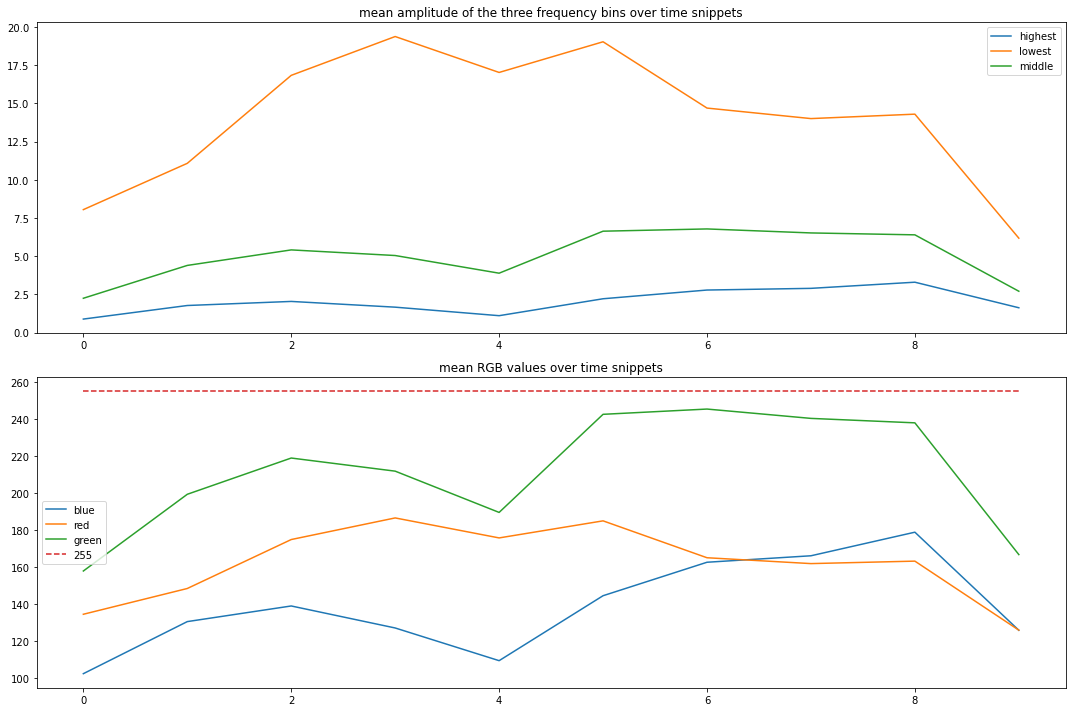

In [17]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[1].plot(np.arange(num_time_bins), b, label="blue")
ax[1].plot(np.arange(num_time_bins), r, label="red")
ax[1].plot(np.arange(num_time_bins), g, label="green")
ax[1].plot([0,num_time_bins-1], [255,255], "--", label="255")
ax[1].legend()
ax[1].set_title("mean RGB values over time snippets")
ax[0].plot(np.arange(num_time_bins), high, label="highest")
ax[0].plot(np.arange(num_time_bins), low, label="lowest")
ax[0].plot(np.arange(num_time_bins), mid, label="middle")
ax[0].legend()
ax[0].set_title("mean amplitude of the three frequency bins over time snippets")
fig.tight_layout()

Depending on the size of the window, we get values that do not exceed 255 while still seeing a decent change in the image.
With 50 we see only a small change, with 100 the channels sometimes saturate and with 70 we get a nice transition.

## Histogram matching method

1. compute each three discrete histograms with 256 bins from the envelope of two adjacent sound samples (-> 6 histograms)
2. compute the difference between each of the three pairs of histograms (-> 3 histograms)
3. compute the histograms of the three color channels of the input image (-> 3 histograms)
4. add the difference to the image histograms to get the histograms of the target image (-> 3 histograms)
5. perform histogram matching: change the initial color channels such that their histograms are distributed like the new histograms
6. put the three new color channels together to form the new image 

### Example for black and white image / only one image channel

get shape of the image channels and determine the scale of change that we want (large number will change the image a lot, smaller number less)

In [23]:
h,w,d = im.shape # image height and with to know the sum of the bins of the image histogram
scale = int(h*w)
print(f"scale of change = {scale}")

scale of change = 367500


function that "discretizes" the envelope of a sound to a histogram of 256 bins

In [18]:
def envelope_to_histogram(sample, scale, plot=False):
    """
    takes sound sample and scale which defines the sum of all bins in the histogram.
    In an image this would be heigt*width = number of pixels
    scale has to be <= the number of pixels in the image channel
    
    returns histogram normalized that would correspond to an image with "scale" pixels
    """
    num_bins = 256 # one bin for each brightness level in an image
    bin_size = int(len(sample1)/num_bins) # the amount of time steps that are summarized in one bin
    if plot:
        print(num_bins, "with size", bin_size)

    binned_envelope = np.array([np.mean(sample[i:i+bin_size]) for i in range(num_bins)])

    # normalize bins to sum=scale
    normalized_float = (binned_envelope/binned_envelope.sum()) * scale
    normalized = normalized_float.astype(int)
    # make sure that the sum is correct after conversion to integer
    while normalized.sum() != scale:
        normalized_float = normalized_float % 1 # get only digits after comma
        idx_biggest_number = np.argmax(normalized_float)
        normalized[np.argmax(normalized_float)] += 1
        normalized_float[idx_biggest_number] = 0
    return normalized

sum should be 367500: True


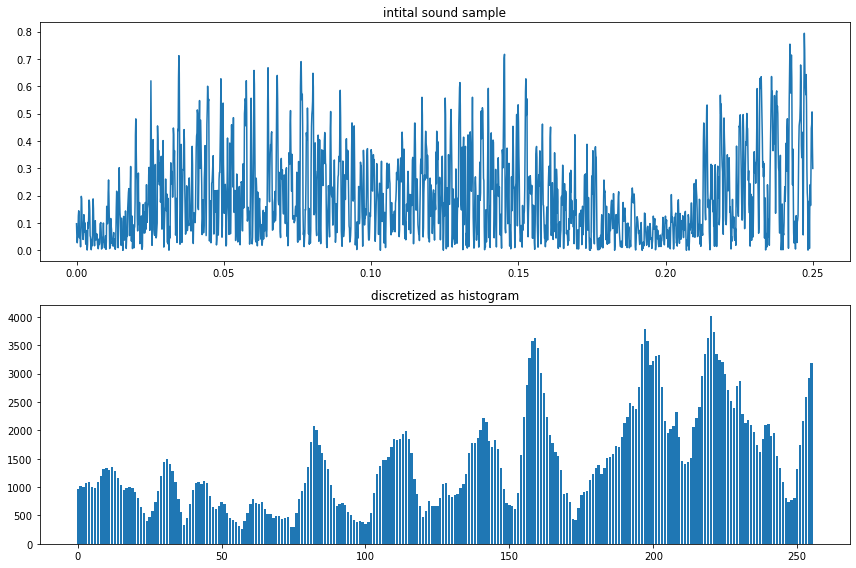

In [58]:
i = 6
sample_len = 2000 # how long the samples are, affects the quality of the histogram

fig, ax = plt.subplots(2,1,figsize=(12,8))
# initial sound sample that should correspond to the initial image histogram
sample1 = audio_pos[sample_len*(i-1):sample_len*i]
ax[0].plot(np.linspace(0,len(sample1)/audio_sample_sf,len(sample1)), sample1)
ax[0].set_title("intital sound sample")

hist1 = envelope_to_histogram(sample1, scale)
print(f"sum should be {scale}: {hist1.sum()==scale}")
        
ax[1].bar(np.arange(256), hist1)
ax[1].set_title("discretized as histogram")
fig.tight_layout()

calculate the histogram of the next snippet

sum should be 367500: True


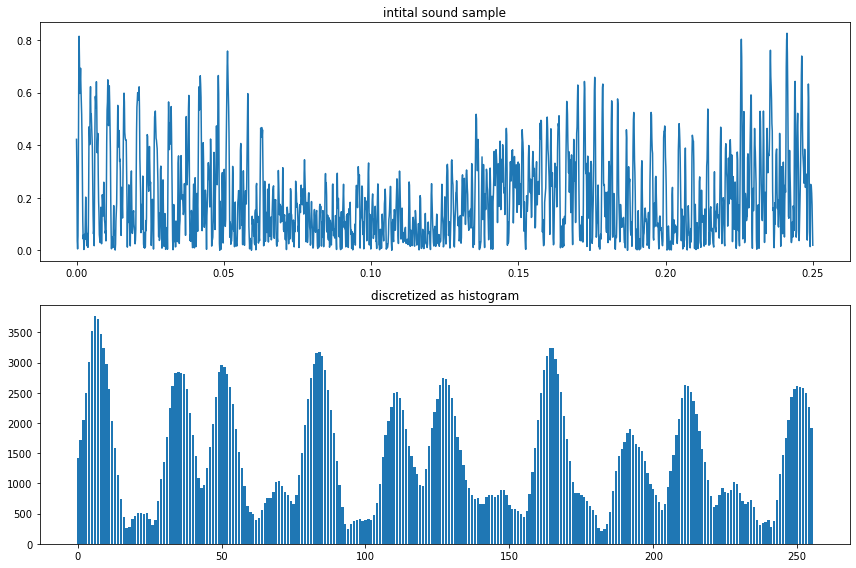

In [59]:
j = i+1
sample2 = audio_pos[sample_len*(j-1):j*sample_len]

fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(np.linspace(0,len(sample2)/audio_sample_sf,len(sample2)), sample2)
ax[0].set_title("intital sound sample")

hist2 = envelope_to_histogram(sample2, scale)
print(f"sum should be {scale}: {hist2.sum()==scale}")

ax[1].bar(np.arange(256), hist2)
ax[1].set_title("discretized as histogram")
fig.tight_layout()

compute the difference between the two histograms

as we know that both histograms have the same amount of "pixels" (sum = scale), the sum of the difference should be 0

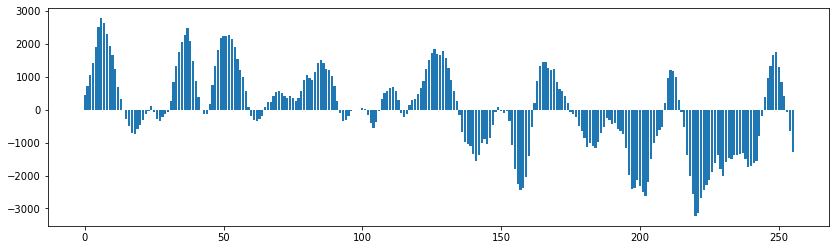

sum should be 0: True. The type needs to be int: int32


In [60]:
diff = (hist2 - hist1).astype(int)
plt.bar(np.arange(256), diff)
plt.show()
print(f"sum should be 0: {diff.sum()==0}. The type needs to be int: {diff.dtype}")
assert(diff.sum()==0)

Now we compute the histogram of the initial image

the image has 367500 pixels


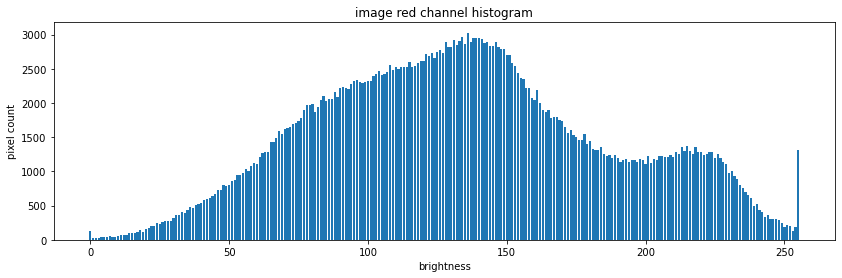

In [61]:
idx, counts = np.unique(im[:,:,0], return_counts = True)
print(f"the image has {np.sum(counts)} pixels")
x_ax = np.arange(256)
hist_im = np.zeros(256, dtype=int)
hist_im[idx] = counts
plt.bar(x_ax, hist_im)
plt.title("image red channel histogram")
plt.ylabel("pixel count")
plt.xlabel("brightness")
plt.show()

We compute the histogram of the new image by adding the calculated difference to the initial image histogram.
We see that we still have integers and that the amount of pixels in the histogram corresponds to the image shape. 

But as the difference can be negative, it can happen that some bins become negative as well. 

We cannot have a negative number of pixel of a certain brightness, therefore we set these bins to 0. 

But then the amount of pixels represented in the histogram does not correspont to the amount of pixels in the image anymore. So we normalize to h*w.

However, the resulting histogram is not of type int anymore, and we cannot have partial pixels of a specific brightness so we cast to int.

Casting to int messes again with the amount of pixels in the histogram because the floats are simply cut off.

dtype=int32, number of pixels=367500==367500=image shape


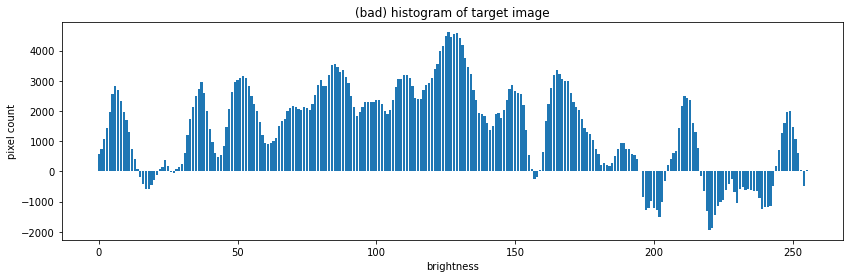

set negative bins to 0 
Pixels in histogram = 404571 vs pixels in image = 367500. dtype=int32
normalized histogram 
Pixels in histogram = 367500.0 vs pixels in image = 367500. dtype=float64, e.g. number of pixels with brightness=0: 525.038
Cast to int 
Pixels in histogram = 367389 vs pixels in image = 367500


In [62]:
y_ax = hist_im + diff
print(f"dtype={y_ax.dtype}, number of pixels={y_ax.sum()}=={h*w}=image shape")
plt.bar(x_ax, y_ax)
plt.title("(bad) histogram of target image")
plt.xlabel("brightness")
plt.ylabel("pixel count")
plt.show()

# in case some bins are negative now set to 0 
y_ax[y_ax<0]=0 # make positive
print(f"set negative bins to 0 \nPixels in histogram = {y_ax.sum()} vs pixels in image = {h*w}. dtype={y_ax.dtype}")

y_ax_float = (y_ax/y_ax.sum())*w*h # normalize again to w*h to have the correct pixel amount
print(f"normalized histogram \nPixels in histogram = {y_ax_float.sum()} vs pixels in image = {h*w}. dtype={y_ax_float.dtype}, e.g. number of pixels with brightness=0: {y_ax_float[0]:.6}")

y_ax = y_ax_float.astype(int)
print(f"Cast to int \nPixels in histogram = {y_ax.sum()} vs pixels in image = {h*w}")

To add again the pixels that were cut off, we manually pick the entry that is closest to the next highest integer and round them up until the sum is correct 

(in the floating point histogram out of e.g. 12.66 and 123.12 we would pick 12.66 and set the corresponding entry in the integer histogram from 12 to 13)

sum should be h*w: True


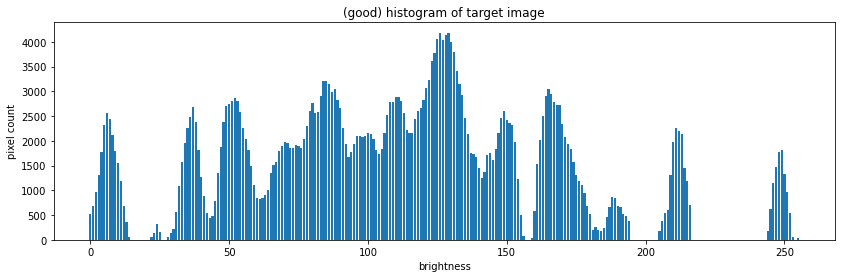

In [63]:
while y_ax.sum() != w*h:
    y_ax_float = y_ax_float % 1 # get only digits after comma
    idx_biggest_number = np.argmax(y_ax_float)
    y_ax[idx_biggest_number] += 1
    y_ax_float[idx_biggest_number] = 0
print(f"sum should be h*w: {h*w==y_ax.sum()}")
assert(h*w==y_ax.sum())

x_ax = np.arange(256)
plt.bar(x_ax, y_ax)
plt.xlabel("brightness")
plt.ylabel("pixel count")
plt.title("(good) histogram of target image")
plt.show()

now we have the histogram of the image that we want to create. Now we need to make an actual image from this histogram to use as reference image in the histogram matching.

The pixel distribution does not matter, it is only important that we have an image with the desired histogram since the method that does the actual matching (match_histograms of scikit image) requires an image as the reference and not a histogram.

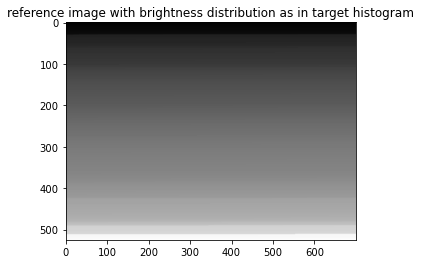

In [64]:
im_ref = np.zeros((h,w), dtype=np.uint8)
intensity_bar = 0 # [0,255] which bar we are in right now
count = 0 # keep track of height of bar
for i in range(h):
    for j in range(w):
        while count == y_ax[intensity_bar]:
            intensity_bar += 1
            count = 0
        im_ref[i,j] = intensity_bar
        count += 1
            
            
plt.imshow(im_ref)
plt.title("reference image with brightness distribution as in target histogram")
plt.show()

Finally, we can map the input image to an image with the given histogram using scikit's function:

uint8 uint8


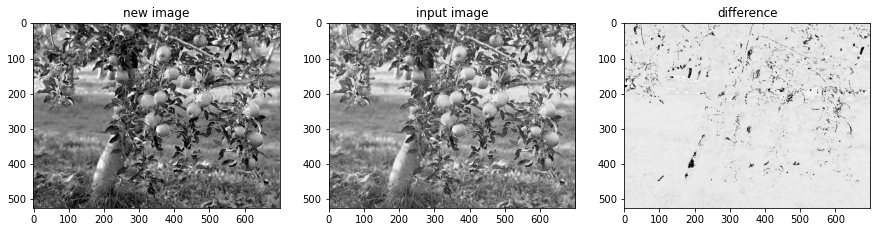

In [65]:
from skimage.exposure import match_histograms

next_im = match_histograms(im[:,:,0], im_ref,multichannel=False).astype(np.uint8)

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(next_im)
ax[0].set_title("new image")
ax[1].imshow(im[:,:,0])
ax[1].set_title("input image")
ax[2].imshow(next_im-im[:,:,0])
ax[2].set_title("difference")
print(im[:,:,0].dtype, next_im.dtype)

check if the histogram of the new image corresponds to the one we want

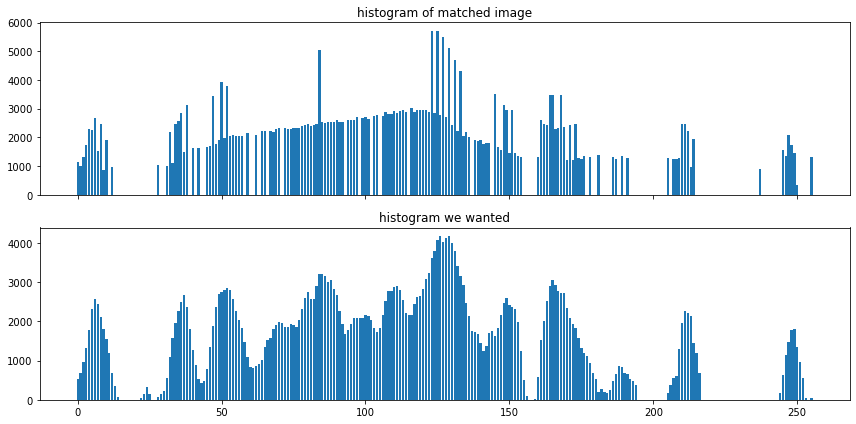

In [66]:
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)

idx, counts = np.unique(next_im, return_counts = True)
hist_im = np.zeros(256, dtype=int)
hist_im[idx] = counts
ax[0].bar(x_ax, hist_im)
ax[0].set_title("histogram of matched image")

ax[1].bar(x_ax, y_ax)
ax[1].set_title("histogram we wanted")
fig.tight_layout()

eh close enough.

put all this stuff in a function:

In [67]:
def get_reference_image(im_channel, diff_sound_hist):
    """
    @param im_channel the image channel we want to change
    @param diff_sound_hist the difference between two sound histograms according to which we want to modify the channel
    get difference of two sound histograms add to initial channel and compute reference image for the channel
    the reference image is an image with the desired histogram but not the image content 
    it can be used for histogram mapping with scipys match_histograms function
    """
    h,w = im_channel.shape
    
    # histogram of initial color channel
    idx, counts = np.unique(im_channel, return_counts = True)
    hist_im = np.zeros(256, dtype=int)
    hist_im[idx] = counts
    
    # add difference to image histogram
    y_ax = hist_im + diff_sound_hist
    
    # perform all this normalization to have the correct pixel amount
    y_ax[y_ax<0]=0 # make positive
    y_ax_float = (y_ax/y_ax.sum())*w*h # normalize again to w*h to have the correct pixel amount
    y_ax = y_ax_float.astype(int)
    while y_ax.sum() != w*h:
        y_ax_float = y_ax_float % 1 # get only digits after comma
        idx_biggest_number = np.argmax(y_ax_float)
        y_ax[idx_biggest_number] += 1
        y_ax_float[idx_biggest_number] = 0
    
    # check that pixel amount is correct
    assert(h*w==y_ax.sum())
    
    # build an image with the desired pixel histogram, the position of each pixel does not matter
    im_ref = np.zeros((h,w), dtype=np.uint8)
    intensity_bar = 0 # [0,255] which bar we are in right now
    count = 0 # keep track of height of bar
    for i in range(h):
        for j in range(w):
            while count == y_ax[intensity_bar]:
                intensity_bar += 1
                count = 0
            im_ref[i,j] = intensity_bar
            count += 1
            
    return im_ref

### color image
Because each color channel has its own histogram we do that for all three color channels:

In [68]:
def get_sub_samples(sample, num=3):
    """
    function that devides a sound sample into three equal sized sound samples (one for each color channel)
    """
    subsample_len = int(len(sample)/3)
    return sample[:subsample_len], sample[subsample_len:subsample_len*2], sample[subsample_len*2:subsample_len*3]

In [69]:
from skimage.exposure import match_histograms
def image_from_histograms(sample1, sample2, im, scale):
    """
    """
    # cut into three subsamples and transform envelopes to histograms
    r1, g1, b1 = (envelope_to_histogram(subsample, scale) for subsample in get_sub_samples(sample1))
    r2, g2, b2 = (envelope_to_histogram(subsample, scale) for subsample in get_sub_samples(sample2))

    # calculate the differences between the three channels
    diff_red = r2-r1
    diff_blue = b2-b1
    diff_green = g2-g1
    print(f"sum should be scale ={scale}: {r1.sum()==scale}, {r2.sum()==scale}, {b1.sum()==scale}, {b2.sum()==scale}, {g1.sum()==scale}, {g2.sum()==scale}")
    print(len(diff_red))
    
    # get reference image for each channel
    ref_im = np.zeros(im.shape)
    ref_im[:,:,0] = get_reference_image(im[:,:,0], diff_red)
    ref_im[:,:,1] = get_reference_image(im[:,:,1], diff_green)
    ref_im[:,:,2] = get_reference_image(im[:,:,2], diff_blue)
    
    # do the actual matching
    new_im = match_histograms(im, ref_im, multichannel=True)
    return new_im

sum should be scale =367500: True, True, True, True, True, True
256


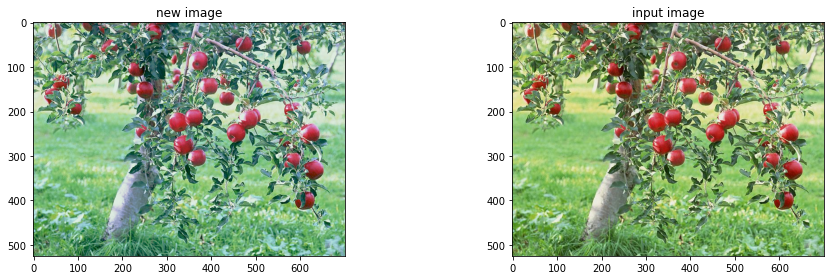

In [70]:
snippet_len = 2000 # 500 time steps for each channel 
sample_len = 3*snippet_len # that means 3 times that many time steps for whole image
audio_pos = audio_sample[audio_sample>=0] # make positive so we can use the mean

# keep the same scale as before
h,w,d = im.shape # image height and with to know the sum of the bins of the image histogram
scale = int(h*w)

# get two consecutive samples
i = 1
sample1 = audio_pos[sample_len*(i-1):i*sample_len]
j = i+1
sample2 = audio_pos[sample_len*(j-1):j*sample_len]

new_im = image_from_histograms(sample1, sample2, im, scale)

fig, ax = plt.subplots(1,2)
ax[0].imshow(new_im)
ax[0].set_title("new image")
ax[1].imshow(im)
ax[1].set_title("input image")
fig.tight_layout()

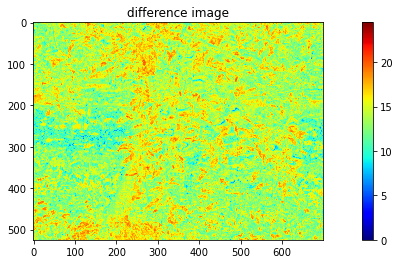

In [71]:
change = np.sqrt(((new_im - im)**2).sum(axis=2))
plt.imshow(change,cmap='jet')
plt.title("difference image")
plt.colorbar()
plt.show()